# Data Analysis Notebook For Hartree-Fock Stability
---

This notebook and the corresponding python file at pyfiles.HFSAnalyzer contain all data analysis and plotting scripts used in the Hatree-Fock Stability of the Homogeneous Electron Gas (HEG). The Data all comes from the executables in the src directory of the project. The logfiles are all in .json format, allowing for easy parsing, while also being human readable (except some large arrays). 

In [1]:
import glob
import math

import sys
sys.path.append('/home/evan/git/QwikPlot/src/')
import qwikplot as qp


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

workdir = '/home/evan/git/HF-Stability/analysis/'
datadir = workdir + 'log'

save_dir = '/home/evan/git/HF-Stability/doc/images'
def savefig(fname,  *args, **kwargs):
    fullname = save_dir + '/' + fname
    plt.savefig(fullname, *args, **kwargs)

def spine(fig=None):
    if fig is None:
        fig = plt.gcf()
    sns.despine(fig, top=False, right=False, left=False, bottom=False)    

sns.set(style='white', font_scale=1, rc=
        {
         'axes.linewidth': 0.5,
         'axes.edgecolor':'black',
         'text.usetex'   : False,
         'axes.spines.left'   : True,  
         'axes.spines.bottom' : True,
         'axes.spines.top'    : True,
         'axes.spines.right'  : True,
         'savefig.transparent' : True,
         'savefig.format': 'eps'
        })

cp = sns.color_palette('colorblind')
cp[1], cp[2] = cp[2], cp[1] # proritize orange over green
sns.set_palette(cp)
    
%matplotlib inline

/home/evan/local/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Load the Data
---

The data is parsed and collected in a pandas dataframe

In [2]:
dataframes = []
for f in glob.glob(datadir + '/*.json'):
    dataframes.append(qp.json_to_df(f, replace={'inf': 'NaN', 'nan': 'NaN'}))
df = pd.concat(dataframes, ignore_index=True)

## Ensure expected typecasts

In [3]:
df['Nk'] = df['Nk'].astype(int)
df['NDIM'] = df['NDIM'].astype(int)
df['mycase'] = df['mycase'].astype(str).str.lstrip().str.rstrip()    
df['rs'] = df['rs'].astype(float)
df['File'] = df['File'].astype(str)
df['total_calculation_time'] = df['total_calculation_time'].astype(float)
df['computation_started'] = pd.to_datetime(df['computation_started'])
df['computation_finished'] = pd.to_datetime(df['computation_finished'])
df['build_date'] = pd.to_datetime(df['build_date'].str.replace('-', ' '))
mask = df['File'].str.contains('scaling_test')
scaling_test = df[mask]
df = df[np.logical_not(mask)]

## Clean Data and simple calcs


In [4]:
# Remove data with critical values missing
df.dropna(axis='rows', subset=['NDIM', 'rs', 'Nk'], inplace=True)

# Of course use_delta_1D must be false for ndim=2, 3
df.loc[np.logical_or(df['NDIM'] == 2, df['NDIM'] == 3), 'use_delta_1D'] = False
df['use_delta_1D'] = df['use_delta_1D'].astype(bool)

df = df.drop_duplicates(subset=['NDIM', 'rs', 'Nk', 'mycase', 'twoE_parameter_1dCase', 'use_delta_1D'])

# The matrix was diagonalized by factoring into A + B and A - B for singlet and triplet cases
# It seems very likely that the offdiagonal components mean that these have equivalent
# eigenvalues, but I was unable to prove this definitively. To be safe, I just did all cases. 
# Thus the actual instability eigenvalue is the minimum of the eigenvalues of A + B and A - B. 
df['triplet_instability'] = df[['dav_triplet_a_minus_b', 'dav_triplet_a_plus_b']].min(axis=1)
df['singlet_instability'] = df[['dav_singlet_a_minus_b', 'dav_singlet_a_plus_b']].min(axis=1)

## Scaling Testing for 2D and 3D case

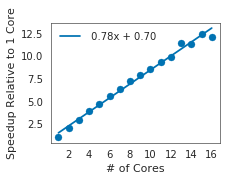

In [5]:
scaling_test['n_per_proc'] = scaling_test['Nmat'] / scaling_test['n_procs']
scaling_test['n_cores'] = scaling_test['n_procs'] // 32

scaling_test = scaling_test[scaling_test.n_cores != 60]

def add_speedup(df):
    min_row = df[df['n_cores'] == min(df['n_cores'])]
    single_core_time = np.average(min_row['total_calculation_time'] * min_row['n_cores'])
    df['Speedup'] = pd.to_numeric(single_core_time) / df['total_calculation_time']
    return df
    
scaling_test = scaling_test.groupby('NDIM').apply(add_speedup)


def linefit(x, y, **kwargs):
    """Wrapper to allow for varied scales in plots"""
    ax = plt.gca()

    plt.scatter(x, y, **kwargs)
  
    coeffs = np.polyfit(x, y, deg=1)
    poly = np.poly1d(coeffs)
    fitfunc = lambda x: poly(x)
    xvals = np.linspace(min(x), max(x), 500)
    line = plt.plot(xvals, fitfunc(xvals), label='{:5.2f}x +{:5.2f}'.format(*coeffs))
    legend = plt.legend(handles=line, loc=0)
    ax.add_artist(legend)
    
    
scaling_test = scaling_test.query('NDIM == 3')
grid = sns.FacetGrid(scaling_test, col='NDIM', sharey=False, sharex=False, size=2.5, aspect=1.3)
grid = grid.map(linefit, 'n_cores', 'Speedup').set_titles("")
grid.set_axis_labels('# of Cores', 'Speedup Relative to 1 Core')
#plt.suptitle('Strong Parallel Scaling')
plt.subplots_adjust(top=0.9)
from matplotlib.ticker import MaxNLocator
#...
ax = plt.gca()
#...

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
spine()
plt.savefig("../doc/images/parallel-scaling.eps", bbox_inches='tight')
plt.show()

## Testing Convergence of Stability Curves with # of K-points

In [6]:
from scipy.interpolate import interp1d
from scipy import optimize

df['Nkpoints'] = df['Nk'] ** df['NDIM']

def crossover(df, x, y, interp1d_args=(), interp1d_kwargs=None, npoints=10**5, cutoff=1e-3):
    temp = df.dropna(subset=[x, y])
    x, y = temp[x], temp[y]
    
    if interp1d_kwargs is None:
        interp1d_kwargs = {}
        
    f = interp1d(x, y, *interp1d_args, **interp1d_kwargs)
    try:
        return optimize.brentq(f, min(x), max(x), xtol=1e-4)
    except ValueError:
        return np.nan

sns.set_palette('colorblind')

trip_onset = (df.groupby(['Nk', 'NDIM', 'Nkpoints'])
        .apply(lambda d: crossover(d, 'rs', 'triplet_instability'))
        .reset_index()
        .rename(columns={0: 'Crossover'})
).dropna()
display(trip_onset)

sing_onset = (df.groupby(['Nk', 'NDIM', 'Nkpoints'])
        .apply(lambda d: crossover(d, 'rs', 'singlet_instability'))
        .reset_index()
        .rename(columns={0: 'Crossover'})
).dropna()
display(sing_onset)


,Nk,NDIM,Nkpoints,Crossover
0,8,3,512,3.903305
1,10,1,10,0.423471
2,16,3,4096,3.943607
3,20,1,20,0.362512
4,24,2,576,0.990904
5,24,3,13824,3.545497
6,30,1,30,0.133680
7,32,3,32768,3.463590
8,34,2,1156,1.012452
9,40,1,40,0.180438


,Nk,NDIM,Nkpoints,Crossover
5,24,3,13824,5.305021
7,32,3,32768,4.754952
8,34,2,1156,2.363476
10,40,3,64000,4.091957
11,44,2,1936,1.875766
12,48,3,110592,3.880648
14,54,2,2916,1.748553
16,64,2,4096,1.529415
18,77,2,5929,1.538895


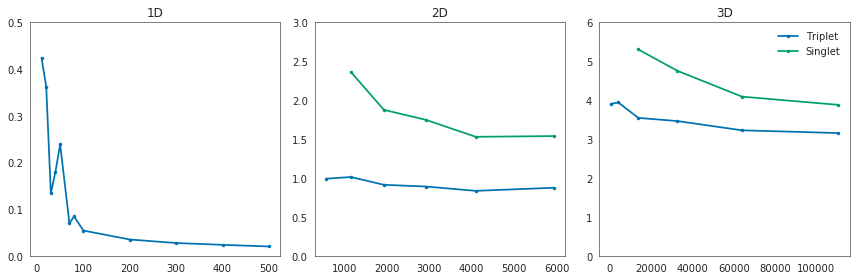

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))

trip = {k: v for k, v in trip_onset.groupby('NDIM')}
sing = {k: v for k, v in sing_onset.groupby('NDIM')}

axes[0].plot(trip[1]['Nkpoints'], trip[1]['Crossover'], '.-', label='Triplet')
#axes[0].plot(sing[1]['Nkpoints'], sing[1]['Crossover'], '.-', label='Singlet')
axes[0].set_title('1D')
axes[0].set_ylim(0, 0.5)


axes[1].plot(trip[2]['Nkpoints'], trip[2]['Crossover'], '.-', label='Triplet')
axes[1].plot(sing[2]['Nkpoints'], sing[2]['Crossover'], '.-', label='Singlet')
axes[1].set_ylim(0, 3)
axes[1].set_title('2D')

axes[2].plot(trip[3]['Nkpoints'], trip[3]['Crossover'], '.-', label='Triplet')
axes[2].plot(sing[3]['Nkpoints'], sing[3]['Crossover'], '.-', label='Singlet')
axes[2].set_ylim(0, 6)
axes[2].set_title('3D')

plt.legend()
plt.tight_layout()
plt.show()

# Finding the crossover rs for highest gridpoints

In [8]:
trip_onset.groupby('NDIM').apply(lambda d: d.loc[d['Nk'].idxmax()]['Crossover'])

NDIM
1    0.019959
2    0.874492
3    3.155415
dtype: float64

# Singlet Stability Curves

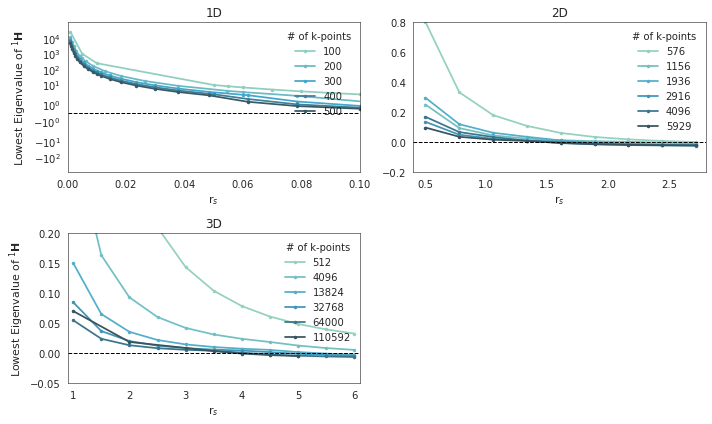

In [130]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6))
subset = (df
          .query('NDIM != 1 or Nk >= 100') # drop low Nk 1D calcs
         )

xlims = ((0, 0.1), (0.4, 2.8), (0.9, 6.1)) 
ylims = ((-10**3, 10**5), (-0.2, 0.8), (-0.05, 0.2))


for xlim, ylim, ax, (ndim, subset) in zip(xlims, ylims, axes.reshape(-1), subset.groupby('NDIM')):
    Nkgroups = subset.groupby('Nk')
    cp = reversed(sns.color_palette("GnBu_d", len(Nkgroups)))
    
    temp = subset[['rs', 'singlet_instability', 'Nkpoints']].pivot(index='rs', columns='Nkpoints')
    temp = temp.reset_index()
    temp = temp.rename(columns={'singlet_instability': 'eval'})
    
    s = temp.to_csv(na_rep="    'NaN'   ", index=False, float_format='%12.5f')
    lines = s.split('\n')[1:]
    header = ','.join(['{:^12}'.format('rs')]  + ['{:^12}'.format('Nk='+s) for s in lines[0].split(',')[1:]])
    lines[0] = header
    s = '\n'.join(lines)
    fname = 'singlet_instability_vs_rs_{}d.csv'.format(ndim)
    with open(fname, 'w') as f:
        f.write(s)
        
    
    for color, (Nk, subsubset) in zip(cp, Nkgroups):
        x = subsubset['rs']
        y = subsubset['singlet_instability']
        x, y = zip(*sorted([tup for tup in zip(x, y)], key=lambda tup: tup[0]))
        ax.plot(x, y, '.-', c=color, label=Nk**ndim)
    
    ax.plot(np.linspace(*xlim, 10**3), np.zeros(10**3), 'k--', linewidth=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('r$_s$')
    ax.set_title(str(ndim) + 'D')
    ax.legend(title='# of k-points')

axes[0,0].set_yscale('symlog')
axes[0,0].set_yticks([-10**2, -1, -10**1, 1, 10**1, 10**2, 10**3, 10**4])
axes[0,0].set_ylabel('Lowest Eigenvalue of ${}^1\mathbf{H}$')
axes[1,0].set_ylabel('Lowest Eigenvalue of ${}^1\mathbf{H}$')

    
axes[1, 1].remove()
plt.tight_layout()
savefig('singlet-stability-convergence.eps')

# Triplet Stability Curves

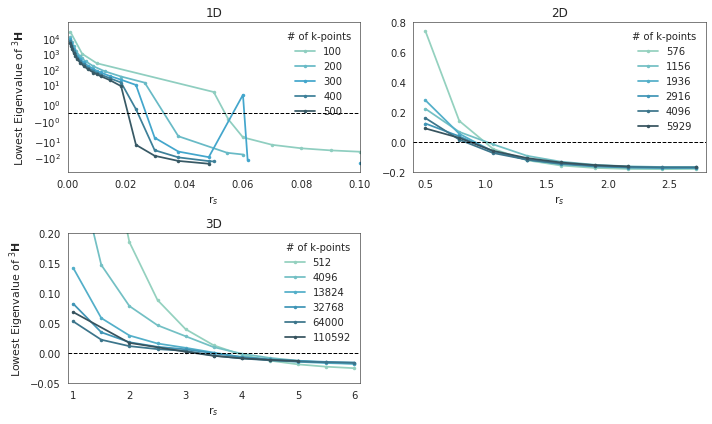

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6))
subset = (df
          .query('NDIM != 1 or Nk >= 100') # drop low Nk 1D calcs
         )

xlims = ((0, 0.1), (0.4, 2.8), (0.9, 6.1)) 
ylims = ((-10**3, 10**5), (-0.2, 0.8), (-0.05, 0.2))


for xlim, ylim, ax, (ndim, subset) in zip(xlims, ylims, axes.reshape(-1), subset.groupby('NDIM')):
    Nkgroups = subset.groupby('Nk')
    cp = reversed(sns.color_palette("GnBu_d", len(Nkgroups)))
    for color, (Nk, subsubset) in zip(cp, Nkgroups):
        x = subsubset['rs']
        y = subsubset['triplet_instability']
        x, y = zip(*sorted([tup for tup in zip(x, y)], key=lambda tup: tup[0]))
        ax.plot(x, y, '.-', c=color, label=Nk**ndim)
    
    ax.plot(np.linspace(*xlim, 10**3), np.zeros(10**3), 'k--', linewidth=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('r$_s$')
    ax.set_title(str(ndim) + 'D')
    ax.legend(title='# of k-points')

axes[0,0].set_yscale('symlog')
axes[0,0].set_yticks([-10**2, -1, -10**1, 1, 10**1, 10**2, 10**3, 10**4])
axes[0,0].set_ylabel('Lowest Eigenvalue of ${}^3\mathbf{H}$')
axes[1,0].set_ylabel('Lowest Eigenvalue of ${}^3\mathbf{H}$')

    
axes[1, 1].remove()
plt.tight_layout()
savefig('triplet-stability-convergence.eps')